# Demonstration of particle filtering for Gompertz and logistic growth models
The code below illustrates how the particle filter (PF) implementation in module gmplgpf.py can be used to model biomass growth. The demo data consists of biomass measured in a shake flask experiment. This notebook is provided as supplement to "Critical Event Prediction for Shake Flask Cultivation by Sequential Importance Sampling of Gompertz and Logistic Growth Models",
B. Pretzner, R. W. Maschke, C. Haiderer, G. T. John, C. Herwig and P. Sykacek. Correspondence should be addressed to <barbara.pretzner@koerber-pharma.com> and <peter.sykacek@boku.ac.at>

(C) P. Sykacek 2021 <peter@sykacek.net>

## Installation of gmplgpf.py and dependencies
The implementation for PF based inference of logistic and Gompertz growth models (PFLgGrw) is largely self contained and depends only on standard Python 3.x, numpy and scipy. Additional Python modules are however required to run this demo notebook. For details about all dependencies check the requirements.txt file in the github repository https://github.com/psykacek/pf4grwth. This is a conda compatible requirements file which was generated with <i> conda list -e > requirements.txt </i>. To meet the requirements the PF code should run inside a conda environment which was prepared with <i>conda create --name "type here your envname" --file requirements.txt</i>. To use the PF for growth models the module gmplgpf.py has to reside in a folder which is in your Python path.

## Generic comments about particle filters and their evaluation
This demo code investigates PF runs on data where the entire growth profile is available. We use complete data to provide impressions of how the proposed PF copes on a global scale. It is however important to keep in mind that PFs are adaptive inference methods. The proposed approach allows in particular for adaptive innovation rates which allow that the filter adjusts gradually between convergence to stationarity and tracking of non stationary situations. The PF will hence in general only be optimal in a local sense. Evaluating global predictive behavior is motivated by intending to predict when the growth process completes and which final yield we may expect. The visualized global behavior of PF predictive accuracy depends however on the degree of stationarity of the analyzed growth profiles and is hence data dependent.

## Data for simulations
All data which were used in the publication "Critical Event Prediction for Shake Flask Cultivation by Sequential Importance Sampling of Gompertz and Logistic Growth Models", (Pretzner <i>et al.</i> 2021) are available in the folder ./growthprofiles/. The folder contains a description with experimental protocol and duration of measurements in the accompanying signal files (<i>experiment name</i>\_bm.csv for the biomass data and <i>experiment name</i>\_o2.csv for the oxygen concentrations). We provide here the calibrated biomass values and oxygen concentration readouts scaled by 10.   

## Hyperparameters of the particle filter
To reduce simulation time, the evaluation in this script uses a reduced number of only 500 particles. We moreover use the default settings in the PFLgGrw constructor for the (diagonal) Gamma prior distributions over all innovation rates (g: 0.05 and h: 0.5). Further details of the adjustable parameters of the PF and their default values are provided in the source module gmplgpf.py. Parameters which we override are documented below.

## Initializing a particle filter for a specific protocol
Particle filters (PFs) are sequential Monte Carlo approaches where model parameters represented by a dynamically evolving set of model parameters (the particles). As is pointed out in (Pretzner <i>et al.</i> 2021) inference benefits from starting with a filter that was previously adjusted to a growth profile which was obtained on the same protocol for which we intend predicting biomass development. Despite that PFs are incrementally updated and allow for tracking non stationary model behavior, we find that convergence and initial predictions are greatly aided by starting with parameters which are "close" to the situation we expect to find in a new experiment. 

## Data preparation

In [1]:
## particle filter initialisation 
##
## (C) P. Sykacek 2021 <peter@sykacek.net>
from IPython import display
%matplotlib inline
from gmplgpf import PFLgGrw
from gmplgpf import NormVals
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
## we turn of all warnings which are a result of
## overflows caused by unsuitable particles which 
## are discarded anyway.
##
## The motivation for filtering warnings is the intent 
## to have less flickering graphical output.
import warnings
warnings.filterwarnings("ignore")
## Load demo experiments from data description. 
## The demo analyses only biomass growth.
indir="./growthprofiles/"
datadesc=pd.read_csv(indir+"datadesc.csv")
## make Name the index
datadesc.set_index("Name", inplace=True, drop=False)
exp4analysis=["LB-250ml-1","TB-500ml-3","LB-250ml-2",
              "TB-500ml-4"]
ifnams=[]
## compile description to ifnams:
for expnam in exp4analysis:
    ifnams.append(indir+datadesc.loc[expnam]["BMdata"])

## PF initialization
After randomizing the biomass growth curve of the TB-500ml-3 experiment we extract 25% of the data to initialize the particle filter. 

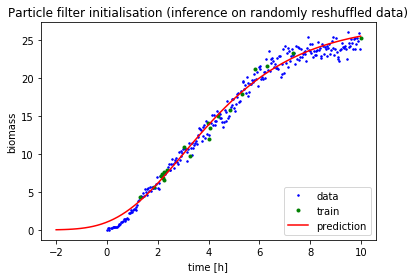

In [2]:
## select one of the 4 files:
ifnam=ifnams[1]
indat=pd.read_csv(ifnam)
allx=indat['x']
signals=indat['y']
## remove the first value which can be done when 
## directly processing data from the instrument by 
## storing the first measurement.
ally=signals-signals[0]
## we cut off after 20 hours.
idsel=allx<20
allx=allx[idsel]
ally=ally[idsel]
## 
if True:
    plt.clf()
    ## initialising the filter
    nwndw=20 ## window size (20 samples in a sliding window constitute X and y)
    ## we use 75 evenly spacer time points for predictions
    in4pred=np.linspace(-2, np.amax(allx), 75)
    ## defining the filter
    ## the following parametes specify the prior distribution which we use for generating
    ## the initial particles
    iniw=np.zeros(2)
    iniL=5*np.eye(2)
    pkmd=2.5
    pkprec=1.0
    plmd=0.0
    plprec=5.0
    maxk=np.inf
    ## no buffering of past samples
    maxinbuff=0
    ## note that we use the Gompertz growth model (set dogomp=False for logistic growth)
    lpf=PFLgGrw(iniw, iniL, pkmd, pkprec, plmd, plprec, maxk=maxk, 
                dogomp=True, addoffs=True, smpwnd=nwndw, innownd=nwndw, 
                nprtcls=500, keeprate=0.075, maxinbuff=maxinbuff)

    ## for a initialisation we permute the indices randomly.
    alldx=np.array(list(range(0, len(allx))))
    doreshuffle=True
    if doreshuffle:
        np.random.shuffle(alldx)
    alldx=list(alldx)
    smprange=[-1]*nwndw
    ## and reduce the reshuffled data to 25% of the entire time course.
    alldx=alldx[0:int(np.ceil(len(alldx)*0.25))]
    ## fitting the particle filter 
    for cnt, idx in enumerate(alldx):
        plt.clf()
        ## add sample idx to filter:
        cx=[allx[idx]]
        cy=ally[idx]
        lpf.addsample(x=cx, y=cy)
        nopwnan=lpf.nopwnan
        ## get predictions at positions in4pred
        if cnt >=20:
            x, ymd, yu, yd=lpf.dopred(in4pred)
        ## smprange is the slice of samples which we have in the data buffer
        smprange=[idx]+smprange[:-1]
        trandx=np.array(smprange)
        trandx=list(trandx[trandx>=0])
        ## plot all samples
        pall=plt.plot(allx, ally, 'b.', markersize=3, label='data')
        ## plot samples in inference buffer
        ptran=plt.plot(allx[trandx], ally[trandx], 'g.', markersize=6, label='train')
        ## diagnostic outpit in title: self.nopwnan self.sumpw
        ## self.nraccLamb self.nracclambn
        nslv=lpf.avprednoise[len(lpf.avprednoise)-1]
        if cnt >=20:
            ## plot predictions at xpred
            pprd=plt.plot(x, ymd, 'r-', label='prediction')
            
        plt.title("Particle filter initialisation (inference on randomly reshuffled data)")
        plt.xlabel("time [h]")
        plt.ylabel("biomass")
        plt.legend(loc="lower right")
        display.display(plt.gcf())
        display.clear_output(wait=True)

## Inferred particle filter
The PF which we inferred on one of the terrific broth shake flask experiments is now parameterized. In practice we would pickle the object and load it when needed for monitoring and predicting experiments which use the same recipe.

## Monitoring and prediction
The initialized PF is capable of adjusting in case biomass growth is non stationary. Such situations may be the result of microbes adapting their metabolism to compensate for changes in their environment (e.g. important resources for one type of metabolism got consumed). For monitoring and prediction we use the PF in its sequential mode of operation.

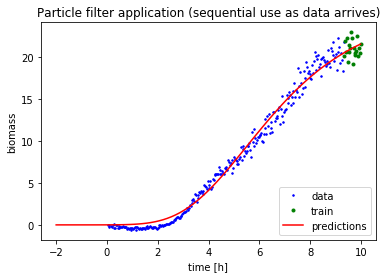

In [3]:
## test predictions on new data (using the same recipe).
ifnam=ifnams[3]
indat=pd.read_csv(ifnam)
allx=indat['x']
signals=indat['y']
## remove the first value which can be done when 
## directly processing data from the instrument by 
## storing the first measurement.
ally=signals-signals[0]
## cut off after 20 hours
keepdx=allx < 20
allx=allx[keepdx]
ally=ally[keepdx]
## use 75 samples for obtaining global predictions
in4pred=np.linspace(-2, np.amax(allx), 75)
## For assessing predictions, we discare the first 20 samples 
## and provide time and biomass concentration in the correct 
## temporal order.
alldx=np.array(list(range(20, len(allx))))
if True:
    ## we initialise the input buffer of the filter.
    lpf.buffcnt=0
    alldx=list(alldx)
    smprange=[-1]*nwndw
    for cnt, idx in enumerate(alldx):
        plt.clf()
        ## add sample idx to filter:
        cx=[allx[idx]]
        cy=ally[idx]
        lpf.addsample(x=cx, y=cy)
        ## get predictions at positions in4pred
        if cnt >=0:
            x, ymd, yu, yd=lpf.dopred(in4pred)
        ## smprange is the slice of samples which we have in the data buffer
        smprange=[idx]+smprange[:-1]
        trandx=np.array(smprange)
        trandx=list(trandx[trandx>=0])
        ## plot all samples
        plt.plot(allx, ally, 'b.', markersize=3, label='data')
        ## plot samples in inference buffer
        plt.plot(allx[trandx], ally[trandx], 'g.', markersize=6, label='train')
        if cnt >=0:
            ## plot predictions at xpred
            plt.plot(x, ymd, 'r-', label='predictions')
            
        plt.title("Particle filter application (sequential use as data arrives)")
        plt.xlabel("time [h]")
        plt.ylabel("biomass")
        plt.legend(loc="lower right")
        display.display(plt.gcf())
        display.clear_output(wait=True)

## Assessment of a-priori predictions with PFs (no prior adaptation to a protocol)
The next experiment initializes a new PF and illustrates a simulation without prior adjustment to a recipe.

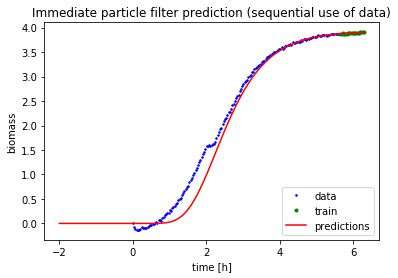

In [4]:
## global predictions on new data withouit intialisations.
ifnam=ifnams[0]
indat=pd.read_csv(ifnam)
allx=indat['x']
signals=indat['y']
## remove the first value which can be done when 
## directly processing data from the instrument by 
## storing the first measurement.
ally=signals-signals[0]
## cut off after 10 hours
keepdx=allx < 10
allx=allx[keepdx]
ally=ally[keepdx]
## use 75 samples for obtaining global predictions
in4pred=np.linspace(-2, np.amax(allx), 75)
## For assessing a uninitialised particle filter, 
## we discared thje first 20 samples and provide time 
## and biomass concentration in the 
## correct temporal order.
alldx=np.array(list(range(20, len(allx))))
if True:
    ## initialise a new particle filter.
    plt.clf()
    ## initialising the filter
    nwndw=20 ## window size (20 samples in a sliding window constitute X and y)
    ## we use 75 evenly spacer time points for predictions
    in4pred=np.linspace(-2, np.amax(allx), 75)
    ## defining the filter
    ## the following parametes specify the prior distribution which we use for generating
    ## the initial particles
    iniw=np.zeros(2)
    iniL=5*np.eye(2)
    pkmd=2.5
    pkprec=1.0
    plmd=0.0
    plprec=5.0
    maxk=np.inf
    ## no buffering of past samples
    maxinbuff=0
    ## note that we use the Gompertz growth model (set dogomp=False for logistic growth)
    lpfn=PFLgGrw(iniw, iniL, pkmd, pkprec, plmd, plprec, maxk=maxk, 
                dogomp=True, addoffs=True, smpwnd=nwndw, innownd=nwndw, 
                nprtcls=500, keeprate=0.075, maxinbuff=maxinbuff)
    alldx=list(alldx)
    smprange=[-1]*nwndw
    for cnt, idx in enumerate(alldx):
        plt.clf()
        ## add sample idx to filter:
        cx=[allx[idx]]
        cy=ally[idx]
        lpfn.addsample(x=cx, y=cy)
        ## get predictions at positions in4pred
        if cnt >=20:
            x, ymd, yu, yd=lpfn.dopred(in4pred)
        ## smprange is the slice of samples which we have in the data buffer
        smprange=[idx]+smprange[:-1]
        trandx=np.array(smprange)
        trandx=list(trandx[trandx>=0])
        ## plot all samples
        plt.plot(allx, ally, 'b.', markersize=3, label='data')
        ## plot samples in inference buffer
        plt.plot(allx[trandx], ally[trandx], 'g.', markersize=6, label='train')
        if cnt >=20:
            ## plot predictions at xpred
            plt.plot(x, ymd, 'r-', label='predictions')
            
        plt.title("Immediate particle filter prediction (sequential use of data)")
        plt.xlabel("time [h]")
        plt.ylabel("biomass")
        plt.legend(loc="lower right")
        display.display(plt.gcf())
        display.clear_output(wait=True)

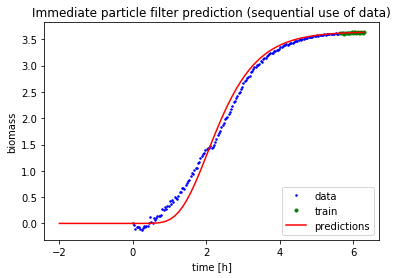

In [5]:
## global predictions on new data without intialisations (second LB experiment).
ifnam=ifnams[2]
indat=pd.read_csv(ifnam)
allx=indat['x']
signals=indat['y']
normby=signals[1:20]
normby=normby[np.isfinite(normby)]
## remove the first value which can be done when 
## directly processing data from the instrument by 
## storing the first measurement.
ally=signals-signals[0]
## cut off after 10 hours
keepdx=allx < 10
allx=allx[keepdx]
ally=ally[keepdx]
## use 75 samples for obtaining global predictions
in4pred=np.linspace(-2, np.amax(allx), 75)
## For assessing a uninitialised particle filter, 
## we discared thje first 20 samples and provide time 
## and biomass concentration in the 
## correct temporal order.
alldx=np.array(list(range(20, len(allx))))
if True:
    ## initialise a new particle filter.
    plt.clf()
    ## initialising the filter
    nwndw=20 ## window size (20 samples in a sliding window constitute X and y)
    ## we use 75 evenly spacer time points for predictions
    in4pred=np.linspace(-2, np.amax(allx), 75)
    ## defining the filter
    ## the following parametes specify the prior distribution which we use for generating
    ## the initial particles
    iniw=np.zeros(2)
    iniL=5*np.eye(2)
    pkmd=2.5
    pkprec=1.0
    plmd=0.0
    plprec=5.0
    maxk=np.inf
    ## no buffering of past samples
    maxinbuff=0
    ## note that we use the Gompertz growth model (set dogomp=False for logistic growth)
    lpfn2=PFLgGrw(iniw, iniL, pkmd, pkprec, plmd, plprec, maxk=maxk, 
                dogomp=True, addoffs=True, smpwnd=nwndw, innownd=nwndw, 
                nprtcls=500, keeprate=0.075, maxinbuff=maxinbuff)
    alldx=list(alldx)
    smprange=[-1]*nwndw
    for cnt, idx in enumerate(alldx):
        plt.clf()
        ## add sample idx to filter:
        cx=[allx[idx]]
        cy=ally[idx]
        lpfn2.addsample(x=cx, y=cy)
        ## get predictions at positions in4pred
        if cnt >=20:
            x, ymd, yu, yd=lpfn2.dopred(in4pred)
        ## smprange is the slice of samples which we have in the data buffer
        smprange=[idx]+smprange[:-1]
        trandx=np.array(smprange)
        trandx=list(trandx[trandx>=0])
        ## plot all samples
        plt.plot(allx, ally, 'b.', markersize=3, label='data')
        ## plot samples in inference buffer
        plt.plot(allx[trandx], ally[trandx], 'g.', markersize=6, label='train')
        if cnt >=20:
            ## plot predictions at xpred
            plt.plot(x, ymd, 'r-', label='predictions')
            
        plt.title("Immediate particle filter prediction (sequential use of data)")
        plt.xlabel("time [h]")
        plt.ylabel("biomass")
        plt.legend(loc="lower right")
        display.display(plt.gcf())
        display.clear_output(wait=True)

## Predictive monitoring with particle filters
To assess predictive monitoring we compare three modes how the PF can be used.

- Application of a naively initialized PF (*unbuffered*).
- Application of a PF which was before initialized with a growth experiment that uses the same experimental protocol (*pretrained*).
- The PF allows to specify that samples (time and corresponding biomass) are randomly retained after they would normally be discarded. This mode of operation still focuses on most recent observations, but also keeps the estimated growth curve close to earlier samples (*buffered*)

To evaluate predictive monitoring we focus on future samples and calculate the mean square errors of all three PF options.

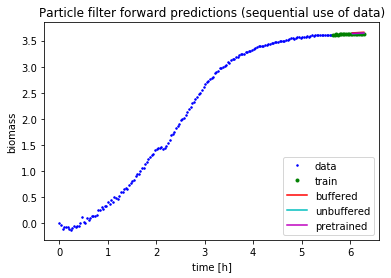

In [6]:
## global predictions on new data without intialisations 
## (second LB experiment). This assessment runs three versions 
## of the PF - one with and one without retaining earlier 
## samples for inference and a third PF without buferiung but 
## pretrained on the same recipe. To assess the global predictive 
## accuracy over time we subsample indices to obtain SSDs over 
## test time.
ifnam=ifnams[0]
indat=pd.read_csv(ifnam)
allx=indat['x']
signals=indat['y']
## remove the first value which can be done when 
## directly processing data from the instrument by 
## storing the first measurement.
ally=signals-signals[0]
## we cuit off after 20 hours.
idsel=allx<10
allx=allx[idsel]
ally=ally[idsel]
## 
if True:
    plt.clf()
    ## initialising the filter
    nwndw=20 ## window size (20 samples in a sliding window constitute X and y)
    ## defining the filter
    ## the following parametes specify the prior distribution which we use for generating
    ## the initial particles
    iniw=np.zeros(2)
    iniL=5*np.eye(2)
    pkmd=2.5
    pkprec=1.0
    plmd=0.0
    plprec=5.0
    maxk=np.inf
    ## no buffering of past samples
    maxinbuff=0
    ## note that we use the Gompertz growth model (set dogomp=False for logistic growth)
    lpf5=PFLgGrw(iniw, iniL, pkmd, pkprec, plmd, plprec, maxk=maxk, 
                 dogomp=True, addoffs=True, smpwnd=nwndw, innownd=nwndw, 
                 nprtcls=500, keeprate=0.075, maxinbuff=maxinbuff)

    ## for a initialisation we permute the indices randomly.
    alldx=np.array(list(range(0, len(allx))))
    doreshuffle=True
    if doreshuffle:
        np.random.shuffle(alldx)
    alldx=list(alldx)
    smprange=[-1]*nwndw
    ## and reduce the reshuffled data to 10% of the entire time course.
    alldx=alldx[0:int(np.ceil(len(alldx)*0.1))]
    ## fitting the particle filter 
    for cnt, idx in enumerate(alldx):
        ## add sample idx to filter:
        cx=[allx[idx]]
        cy=ally[idx]
        lpf5.addsample(x=cx, y=cy)
## clear inpit buffer of lpf5
lpf5.buffcnt=0
## lpf5 is initialised and we switch to evaluation
ifnam=ifnams[2]
indat=pd.read_csv(ifnam)
allx=indat['x']
signals=indat['y']
## remove the first value which can be done when 
## directly processing data from the instrument by 
## storing the first measurement.
ally=signals-signals[0]
## cut off after 6.5 hours (as after that we have a decay)
keepdx=allx < 6.5
allx=allx[keepdx]
ally=ally[keepdx]
## use 100 samples for prediction and evaluiaton
id4pred=np.array(list(range(0,len(allx),int(len(allx)/100))))
in4pred=allx[id4pred]
trg4pred=ally[id4pred]
## For assessing a uninitialised particle filter, 
## we discared thje first 20 samples and provide time 
## and biomass concentration in the 
## correct temporal order.
alldx=np.array(list(range(20, len(allx))))
if True:
    ## initialise a new particle filter.
    plt.clf()
    ## initialising the filter
    nwndw=20 ## window size (20 samples in a sliding window constitute X and y)
    ## defining the filter
    ## the following parametes specify the prior distribution which we use for generating
    ## the initial particles
    iniw=np.zeros(2)
    iniL=5*np.eye(2)
    pkmd=2.5
    pkprec=1.0
    plmd=0.0
    plprec=5.0
    maxk=np.inf
    ## buffering of 25 randomly selected past samples
    maxinbuff=25
    ## note that we use the Gompertz growth model (set dogomp=False for logistic growth)
    lpfn3=PFLgGrw(iniw, iniL, pkmd, pkprec, plmd, plprec, maxk=maxk, 
                dogomp=True, addoffs=True, smpwnd=nwndw, innownd=nwndw, 
                nprtcls=500, keeprate=0.075, maxinbuff=maxinbuff)
    ## and comparison without buffering
    lpfn4=PFLgGrw(iniw, iniL, pkmd, pkprec, plmd, plprec, maxk=maxk, 
                dogomp=True, addoffs=True, smpwnd=nwndw, innownd=nwndw, 
                nprtcls=500, keeprate=0.075, maxinbuff=0)
    alldx=list(alldx)
    smprange=[-1]*nwndw
    ## buffers for ssds and time at prediction
    msebf=[]
    msenbf=[]
    msept=[]
    ptm=[]
    for cnt, idx in enumerate(alldx):
        plt.clf()
        ## add sample idx to filter:
        cx=[allx[idx]]
        cy=ally[idx]
        lpfn3.addsample(x=cx.copy(), y=cy.copy())
        lpfn4.addsample(x=cx.copy(), y=cy.copy())
        lpf5.addsample(x=cx.copy(), y=cy.copy())
        ## get predictions at positions in4pred
        if cnt >=10 and cnt % 10==0:
            ## generate inputs and targets for forward predictions
            id4pred=np.array(alldx)
            id4pred=id4pred[id4pred>idx]
            in4pred=allx[id4pred]
            trg4pred=ally[id4pred]
            ## time when prediction is made
            ptm.append(cx)
            xbf, ybf, yu, yd=lpfn3.dopred(in4pred)
            msebf.append(np.sum((ybf-trg4pred)**2)/len(ybf))
            xnbf, ynbf, yu, yd=lpfn4.dopred(in4pred)
            msenbf.append(np.sum((ynbf-trg4pred)**2)/len(ynbf))
            xpt, ypt, yu, yd=lpf5.dopred(in4pred)
            msept.append(np.sum((ypt-trg4pred)**2)/len(ypt))
        ## smprange is the slice of samples which we have in the data buffer
        smprange=[idx]+smprange[:-1]
        trandx=np.array(smprange)
        trandx=list(trandx[trandx>=0])
        ## plot all samples
        plt.plot(allx, ally, 'b.', markersize=3, label='data')
        ## plot samples in inference buffer
        plt.plot(allx[trandx], ally[trandx], 'g.', markersize=6, label='train')
        if cnt >=10:
            ## plot predictions at xpred
            plt.plot(xbf, ybf, 'r-', label='buffered')
            plt.plot(xnbf, ynbf, 'c-', label='unbuffered')
            plt.plot(xpt, ypt, 'm-', label='pretrained')
        plt.title("Particle filter forward predictions (sequential use of data)")
        plt.xlabel("time [h]")
        plt.ylabel("biomass")
        plt.legend(loc="lower right")
        display.display(plt.gcf())
        display.clear_output(wait=True)

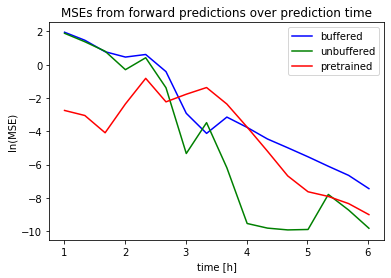

In [7]:
## visualisation of MSE of forward predicitons over time
plt.clf()
plt.plot(ptm, np.log(msebf), 'b-', label='buffered')
plt.plot(ptm, np.log(msenbf), 'g-', label='unbuffered')
plt.plot(ptm, np.log(msept), 'r-', label='pretrained')
plt.title("MSEs from forward predictions over prediction time")
plt.xlabel("time [h]")
plt.ylabel("ln(MSE)")
plt.legend(loc="upper right")
plt.show()

## Conclusion
Particle filters are sequential inference methods. A PF based estimation of growth curves can in principle be bootstrapped from randomly initialized particles. Our simulations reveal however that initializing PFs by training on biomass profiles which were obtained on identical growth media is beneficial. We observe in the above simulations that a naively initialized PF is particularly challenged with inferring accurate values for the limit biomass parameter when only presented with initial measurements. The simulations suggest that **recipe specific pretraining** of PF growth models is recommended. The initialized filter provides in particular in the first half of the growth process much better predictions. In the second half of the growth experiment the particle filter without buffering provides superior results.